In [1]:
!pip install torchxrayvision

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 42.4 MB 1.0 MB/s  eta 0:00:01


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
from torch.optim import Adam
import pytorch_lightning as pl
import torchxrayvision as xrv

from data_loaders import get_data_loader
from utils.visualisation import showInRow
import pandas as pd
from skimage import io, color
from skmultilearn.model_selection import iterative_train_test_split

from PIL import Image
import pydicom as dicom
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [23]:
transform=transforms.Compose([transforms.Grayscale(),
                              transforms.Resize((128,128)),
                              transforms.ToTensor(),
                              #transforms.Normalize((0.5,), (0.5,))
                             ])

In [2]:
d = get_data_loader("Chest14", part="train_val")
len(d)

86524

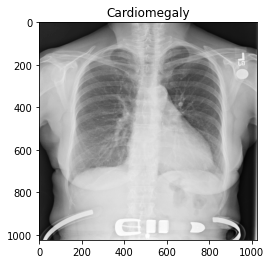

In [3]:
sample = d[15]
showInRow([sample['image']], [sample['label']])

# Split data on train val test splits

In [7]:
train_len = int(len(dataset_train) * (1-VAL_SPLIT))
val_len = len(dataset_train) - train_len

print("Before splitting:")
print("\tTrain dataset:", len(dataset_train))
print("\tTest dataset:", len(dataset_test))

dataset_train, dataset_val = random_split(dataset_train, (train_len, val_len))


print("After splitting:")
print("\tTrain dataset:", len(dataset_train))
print("\tVal dataset:", len(dataset_val))
print("\tTest dataset:", len(dataset_test))

Before splitting:
	Train dataset: 86524
	Test dataset: 25596
After splitting:
	Train dataset: 69219
	Val dataset: 17305
	Test dataset: 25596


# Define data loaders

In [1]:
class MyModel(pl.LightningModule):
    
    def __init__(self, class_num):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 29 * 29, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, class_num)
        
        self.accuracy = pl.metrics.Accuracy()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 16 * 29 * 29)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.sigmoid(x)
    
    def training_step(self, batch, batch_idx):
        images, labels = \
            batch['image'], batch['one_hot_label']
        images = images.cuda()
        labels = labels.cuda()
        logits = self(images)
        
        
        loss = self.categorical_cross_entropy(logits, labels)
        return loss
    
    def test_step(self, batch, batch_idx):
        images, labels = batch['image'], batch['one_hot_label']
        logits = self(images)
        loss = F.nll_loss(logits, labels)
        print('test_loss', loss)
    
    def categorical_cross_entropy(self, predictions, labels):
        epsilon=1e-12
        predictions = torch.clamp(predictions, epsilon, 1. - epsilon)
        N = len(predictions)
        loss = -torch.sum(labels * torch.log(predictions+1e-9))/N
        return loss
    
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)
    
    def train_dataloader(self):
        return DataLoader(dataset_train, batch_size=BATCH_SIZE, 
                          num_workers=WORKERS)

    def val_dataloader(self):
        return DataLoader(dataset_val, batch_size=BATCH_SIZE,
                          num_workers=WORKERS)

    def test_dataloader(self):
        return DataLoader(dataset_test, batch_size=BATCH_SIZE, 
                          num_workers=WORKERS)

NameError: name 'pl' is not defined

In [9]:
model = MyModel(15)
if torch.cuda.is_available():
    model = model.cuda()

In [11]:
trainer = pl.Trainer(gpus=1)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
/home/intern/.local/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)
/home/intern/.local/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name     | Type      | Params
---------------------------------------
0 | conv1    | Conv2d    | 156   
1 | pool     | MaxPool2d | 0     
2 | conv2    | Conv2d    | 2 K   
3 | fc1      | Linear    | 1 M   
4 | fc2      | Linear    | 10 K  
5 | fc3      | Linear    | 1 K   
6 | accuracy | Accuracy  | 0     
/home/intern/.local/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: Us

/home/intern/.local/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


/home/intern/.local/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning: The metric you returned None must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of loss in validation_epoch_end()?
  warnings.warn(*args, **kwargs)
/home/intern/.local/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning: Can save best model only with loss available, skipping.
  warnings.warn(*args, **kwargs)


1

In [18]:
sample1 = dataset_train[7]
img, lab = sample['image'], sample['one_hot_label']
img = torch.unsqueeze(img, 0).cuda()
lab = lab.cuda()
model.cuda()
model(img)

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],
       device='cuda:0', grad_fn=<SigmoidBackward>)

In [42]:
trainer.test(model)

/home/intern/.local/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'target' in call to _thnn_nll_loss_forward

In [33]:
sample1 = dataset_train[1]
sample2 = dataset_train[6]

lab1 = sample1['one_hot_label']
lab2 = sample2['one_hot_label']
print(lab1)
print(lab2)

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [213]:
model.categorical_cross_entropy(lab1, lab2)

tensor(-0.)

In [226]:
len(lab1)

15

In [222]:
torch.cuda.get_device_name()

'GeForce GTX 1080 Ti'

In [234]:
torch.cuda.current_device() 

0

In [34]:
accuracy = pl.metrics.Accuracy()
accuracy(lab1, lab1)

tensor(1.)